<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/PCA_sound_compression/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



import warnings
warnings.filterwarnings("ignore")

## Synthetic example

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


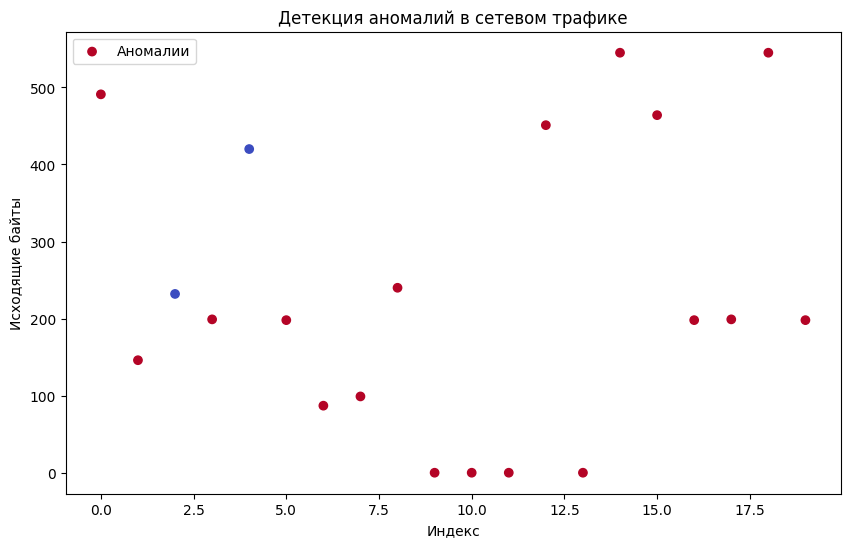

In [1]:
data = {
    'duration': [0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0],
    'src_bytes': [491, 146, 232, 199, 420, 198, 87, 99, 240, 0, 0, 0, 451, 0, 545, 464, 198, 199, 545, 198],
    'dst_bytes': [0, 0, 8153, 420, 5450, 199, 87, 545, 5450, 545, 198, 198, 240, 0, 545, 198, 198, 545, 198, 198],
}

df = pd.DataFrame(data)

features = ['duration', 'src_bytes', 'dst_bytes']
X = df[features]

model = IsolationForest(contamination=0.1)
df['anomaly'] = model.fit_predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['src_bytes'], c=df['anomaly'], cmap='coolwarm', label='Аномалии')
plt.title('Детекция аномалий в сетевом трафике')
plt.xlabel('Индекс')
plt.ylabel('Исходящие байты')
plt.legend()
plt.show()


## Synthetic network traffic

In [2]:

!kaggle datasets download -d vidhikishorwaghela/synthetic-network-traffic

Dataset URL: https://www.kaggle.com/datasets/vidhikishorwaghela/synthetic-network-traffic
License(s): unknown
 92% 81.0M/87.9M [00:00<00:00, 86.2MB/s]
100% 87.9M/87.9M [00:00<00:00, 92.9MB/s]


In [3]:

!unzip synthetic-network-traffic.zip

Archive:  synthetic-network-traffic.zip
  inflating: synthetic_network_traffic.csv  


In [8]:
data = pd.read_csv('synthetic_network_traffic.csv')

In [11]:
data['TotalBytes'] = data['BytesSent'] + data['BytesReceived']
data['TotalPackets'] = data['PacketsSent'] + data['PacketsReceived']
anomaly_data = data[data['IsAnomaly'] == 1]
oversampled_data = pd.concat([data, anomaly_data], axis=0)

X = oversampled_data.drop(columns=['IsAnomaly'])  # Features
y = oversampled_data['IsAnomaly']  # Labels

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)
y_pred_iforest = isolation_forest.predict(X_test)
y_pred_iforest = (y_pred_iforest == -1)

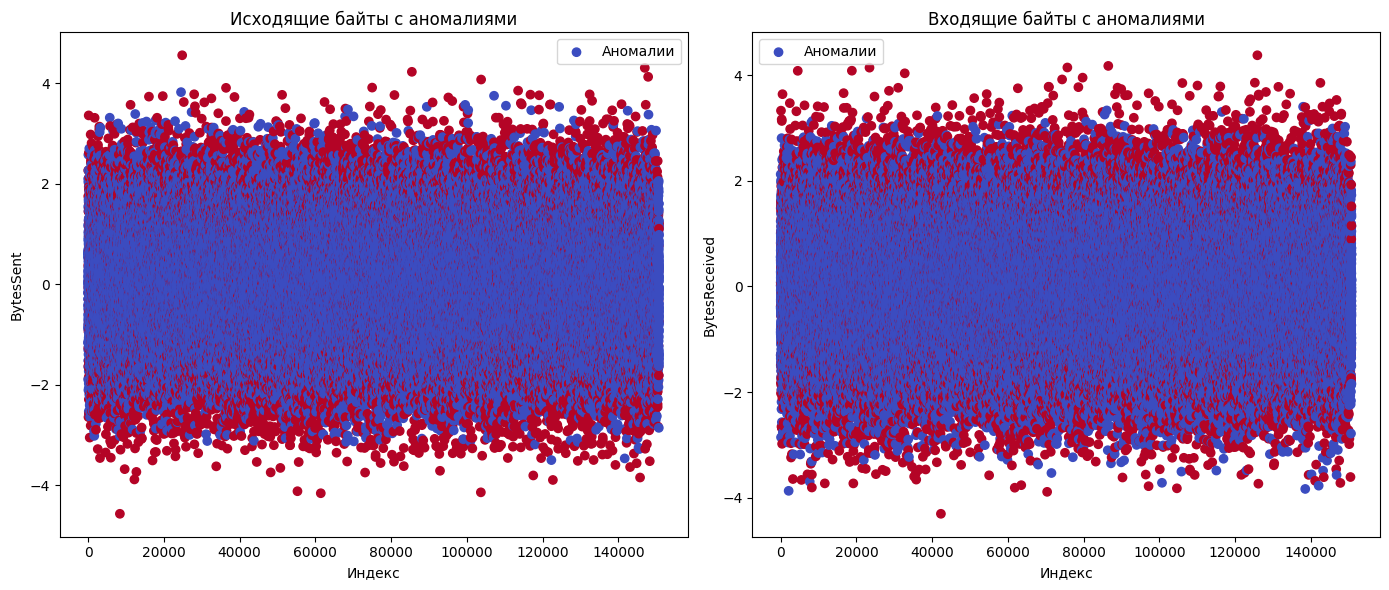

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.scatter(range(len(X_test)), X_test[:, X.columns.get_loc('BytesSent')], c=y_pred_iforest, cmap='coolwarm', label='Аномалии')
plt.title('Исходящие байты с аномалиями')
plt.xlabel('Индекс')
plt.ylabel('BytesSent')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(X_test)), X_test[:, X.columns.get_loc('BytesReceived')], c=y_pred_iforest, cmap='coolwarm', label='Аномалии')
plt.title('Входящие байты с аномалиями')
plt.xlabel('Индекс')
plt.ylabel('BytesReceived')
plt.legend()

plt.tight_layout()
plt.show()

## Credic card fraud

In [15]:

!kaggle datasets download -d mlg-ulb/creditcardfraud

!unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 76% 50.0M/66.0M [00:00<00:00, 112MB/s]
100% 66.0M/66.0M [00:00<00:00, 126MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


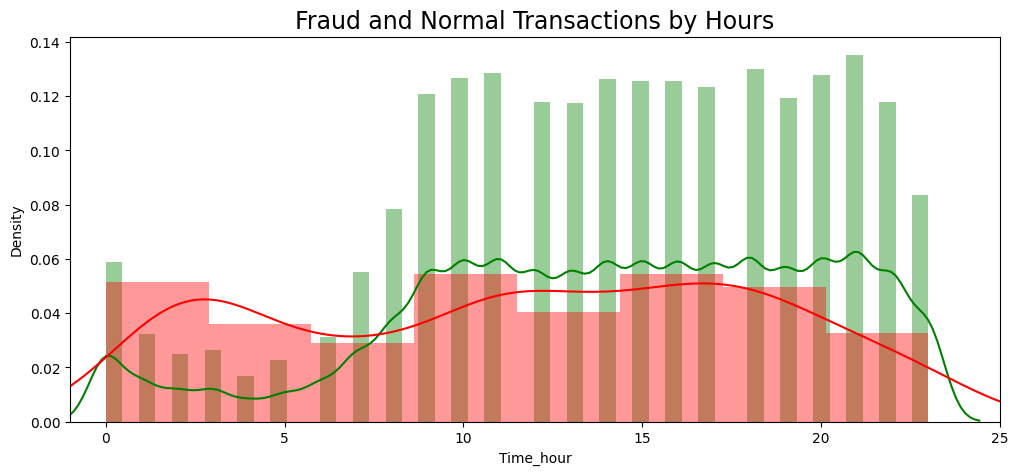

In [17]:
df = pd.read_csv('creditcard.csv')

# Обработка данных
df['Time'] = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = df['Time'].dt.components.hours

# Визуализация распределения нормальных и мошеннических транзакций по времени
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()




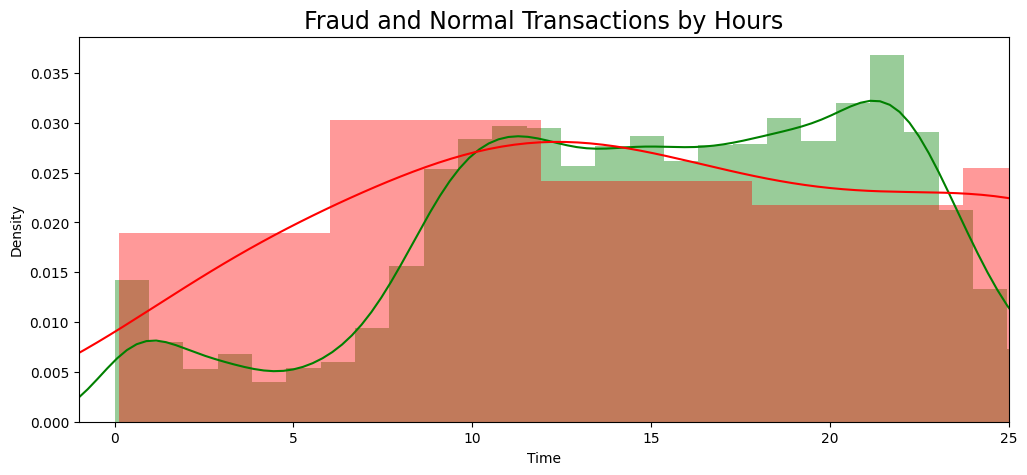

In [22]:
# Загрузка данных
df = pd.read_csv('creditcard.csv')

# Преобразование времени из секунд в часы
df['Time'] = df['Time'] / 3600  # Преобразуем секунды в часы

# Визуализация распределения нормальных и мошеннических транзакций по времени
plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time"], color='g')
sns.distplot(df[df['Class'] == 1]["Time"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()
# Трансформация признаков с использованием PCA
cols = df[['Time', 'Amount']]
pca = PCA()
X_PCA = pca.fit_transform(cols)
df['V29'] = X_PCA[:, 0]
df['V30'] = X_PCA[:, 1]
df.drop(['Time', 'Amount'], axis=1, inplace=True)

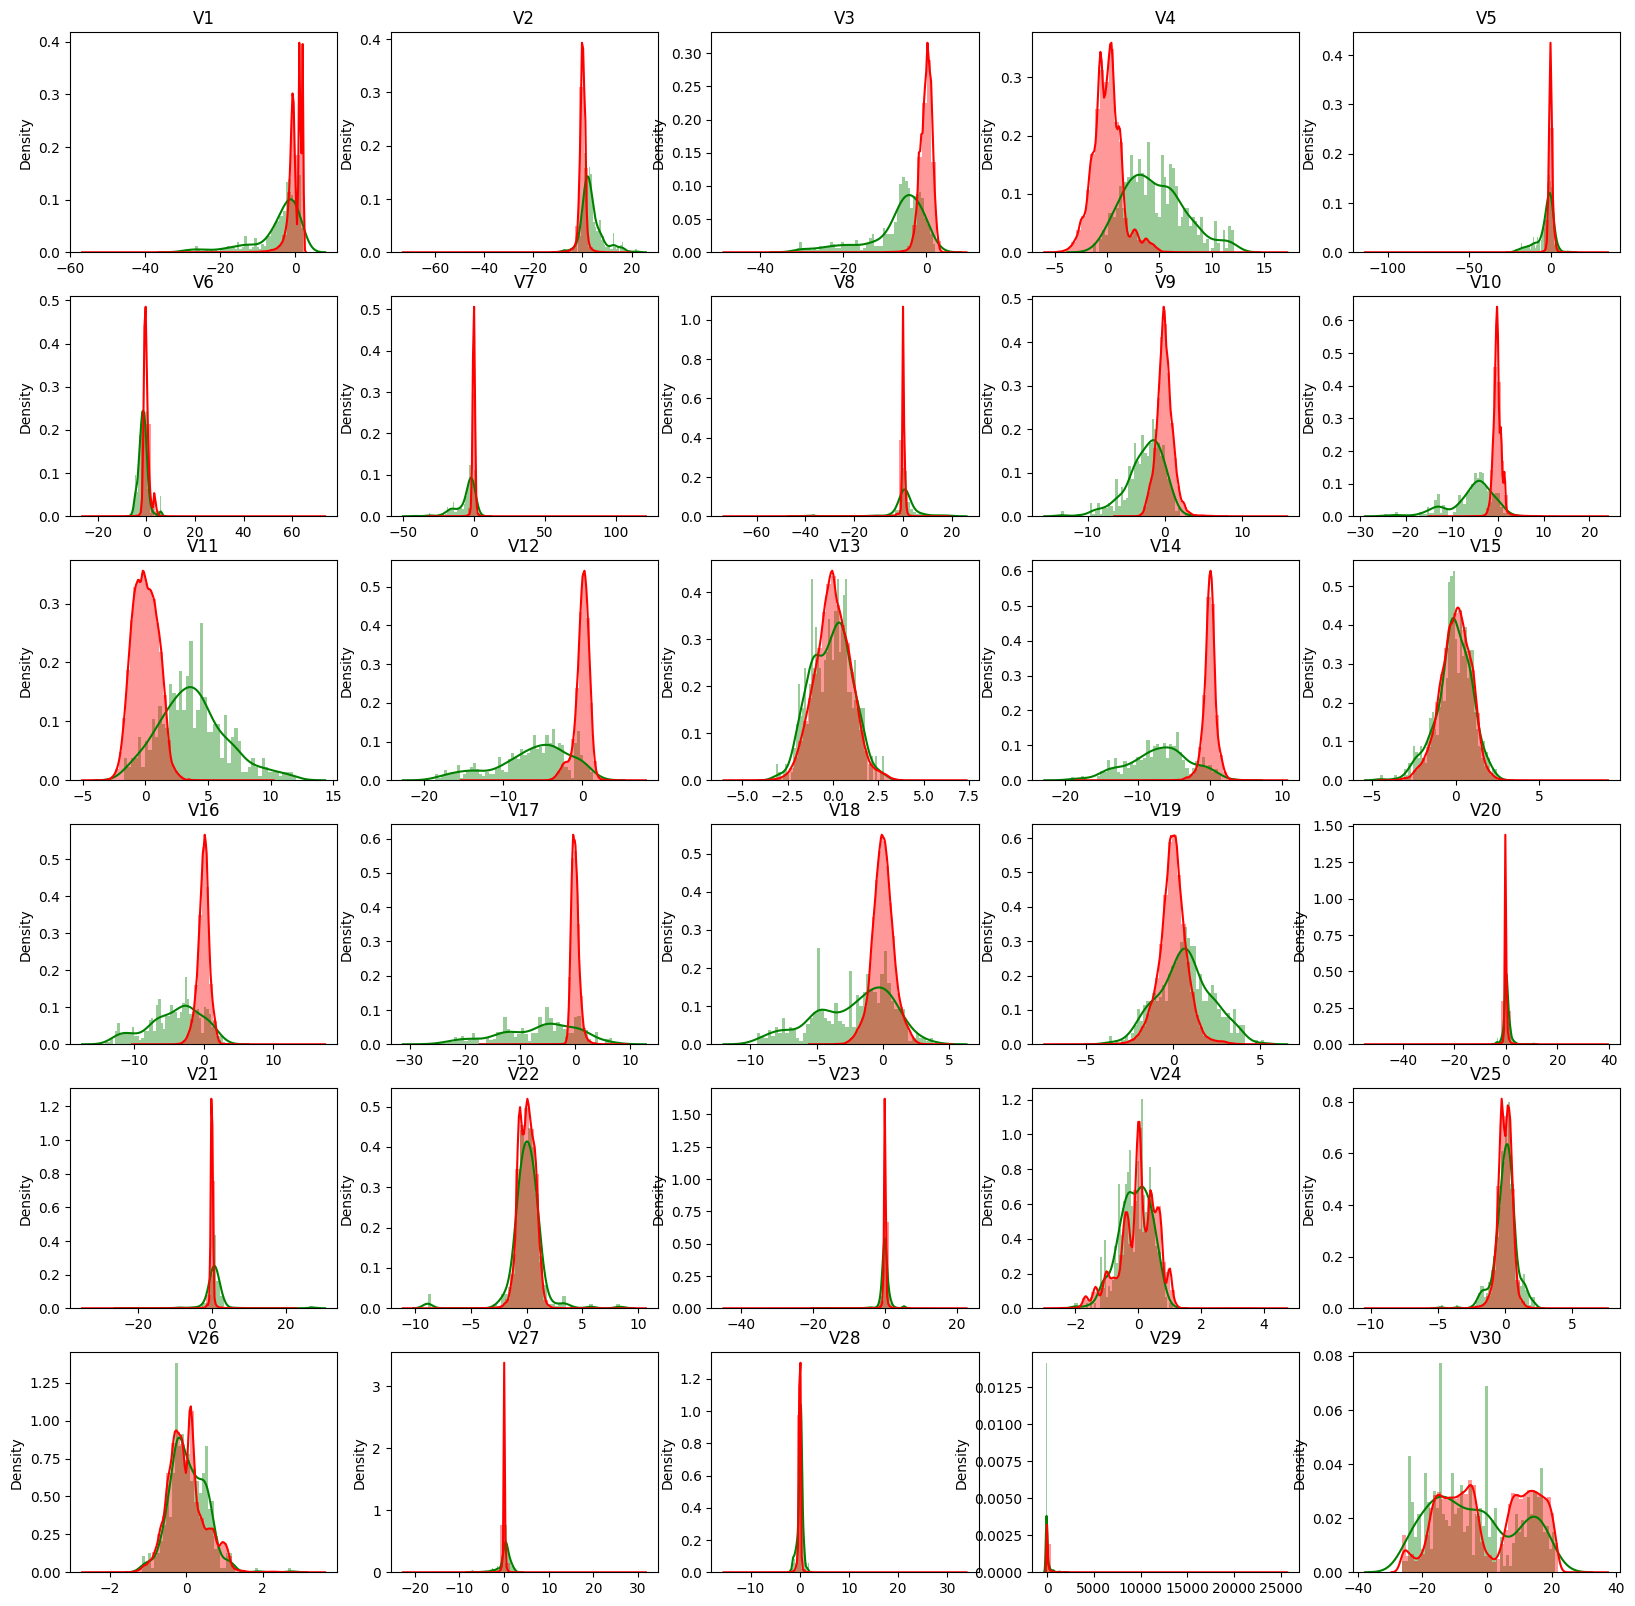

In [23]:

# Визуализация распределения признаков
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)
plt.figure(figsize=(20, 10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins=50, color='g')
    sns.distplot(df[df.Class==0][col], bins=50, color='r')
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

In [24]:

# Выбор значимых признаков с использованием Z-теста
def ztest(feature):
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    return zScore

columns = df.drop('Class', axis=1).columns
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
sample_size = len(fraud)
significant_features = []
critical_value = 2.58


for i in columns:
    z_value = ztest(i)
    if(abs(z_value) >= critical_value):
        significant_features.append(i)

significant_features.append('Class')
df = df[significant_features]

In [25]:

# Разделение данных на нормальные и аномальные транзакции
inliers = df[df.Class == 0]
ins = inliers.drop(['Class'], axis=1)

outliers = df[df.Class == 1]
outs = outliers.drop(['Class'], axis=1)


In [26]:


# Обучение и оценка моделей
def normal_accuracy(values):
    tp = list(values).count(1)
    total = values.shape[0]
    accuracy = np.round(tp/total, 4)
    return accuracy

def fraud_accuracy(values):
    tn = list(values).count(-1)
    total = values.shape[0]
    accuracy = np.round(tn/total, 4)
    return accuracy

state = 42


In [27]:

ISF = IsolationForest(random_state=state)
ISF.fit(ins)
normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)
in_accuracy_isf = normal_accuracy(normal_isf)
out_accuracy_isf = fraud_accuracy(fraud_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)


Accuracy in Detecting Normal Cases: 0.9597
Accuracy in Detecting Fraud Cases: 0.872


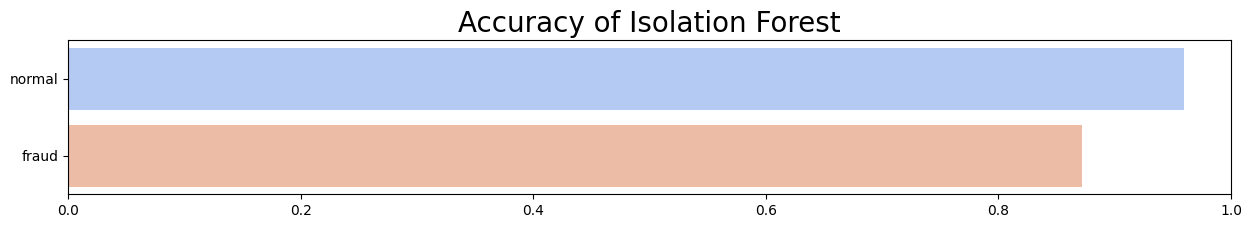

In [30]:
plt.figure(figsize=[15, 2])
plt.title("Accuracy of Isolation Forest", fontsize=20)
sns.barplot(x=[in_accuracy_isf, out_accuracy_isf], y=['normal', 'fraud'], palette='coolwarm')
plt.xlim(0, 1)
plt.show()

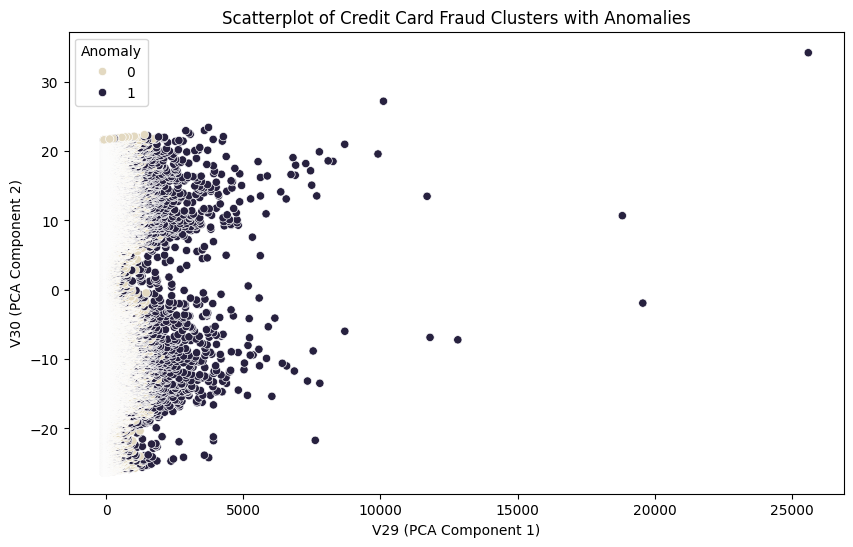

In [38]:
# Визуализация кластеров с использованием scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='V29', y='V30', hue='anomaly', palette="ch:s=-.2,r=.6")
plt.title('Scatterplot of Credit Card Fraud Clusters with Anomalies')
plt.xlabel('V29 (PCA Component 1)')
plt.ylabel('V30 (PCA Component 2)')
plt.legend(title='Anomaly')
plt.show()